# Intro to Ray Data:  Ray Data + Unstructured Data

© 2025, Anyscale. All Rights Reserved

💻 **Launch Locally**: You can run this notebook locally, but performance will be reduced.

🚀 **Launch on Cloud**: A Ray Cluster (Click [here](http://console.anyscale.com/register) to easily start a Ray cluster on Anyscale) is recommended to run this notebook.

This notebook will provide an overview of Ray Data and how to use it to read, transform and write data in a distributed manner.

<div class="alert alert-block alert-info">
<b> Here is the roadmap for this notebook:</b>
<ul>
  <li>When and why to use Ray Data?</li>
  <li>How to work with Ray Data</li>
  <li>Loading data</li>
  <li>Ray Data key concepts</li>
  <li>Lazy execution mode</li>
  <li>Transforming data</li>
  <li>Stateful transformations with Ray Actors</li>
  <li>Materializing data</li>
  <li>Data operations: grouping, aggregation, and shuffling</li>
  <li>Persisting data</li>
  <li>Ray Data in production</li>
</ul>
</div>

**Imports**

In [1]:
import subprocess
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import Compose, ToTensor, Normalize

import ray

## 1. When to Consider Ray Data

Consider using Ray Data for your project if it meets one or more of the following criteria:

| **Challenge** | **Details** | **Ray Data Solution** |
|---------------|-------------|------------------------|
| **Operating on large datasets and/or models** | - Having to load and process massive datasets or models (e.g., >10 TB) <br>- Having to perform inference with large models (e.g., LLMs) using inference engines | - Distributes data loading and processing across a Ray cluster <br>- Supports large model inference workloads via [ray.data.llm](https://docs.ray.io/en/latest/data/working-with-llms.html) |
| **Efficient hardware utilization across CPUs and GPUs** | - Over-provisioning compute to naively partition data <br>- Performing static resource allocation <br>- Running execution in full across CPU and GPU stages <br>- Passing data between heteregenous stages by persisting intermediate results to disk  | - [Streams data](https://docs.ray.io/en/latest/data/data-internals.html#streaming-execution) to avoid full materialization in memory <br>- Enables resource multiplexing across pipeline stages <br>- Supports autoscaling for both CPU and GPU resources <br>- Enables pipeline parallelism across heterogeneous hardware with [configurable batch sizes](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches) |
| **Building reliable pipelines** | - Needing to handle failures such as network errors, spot instance preemptions, and hardware faults | - Leverages [Ray Core’s fault-tolerance mechanisms](https://docs.ray.io/en/latest/ray-core/fault-tolerance.html) to recover from failed tasks <br>- Supports [driver checkpointing](https://docs.anyscale.com/rayturbo/rayturbo-data/#job-level-checkpointing) (via RayTurbo) for comprehensive pipeline reliability |
| **Handling unstructured data efficiently** | - Suboptimal resource allocation due to data skew in input data sizes (e.g. vary input video lengths)  | - Automatically [reshapes data into uniformly sized blocks](https://docs.ray.io/en/latest/data/data-internals.html) to improve processing efficiency |


|<img src="https://docs.ray.io/en/releases-2.6.1/_images/stream-example.png" width="70%" loading="lazy">|
|:--|
|Example batch inference pipeline with Ray Data over a large dataset using heterogeneous cluster of CPUs and GPUs.|

## 2. How to work with Ray Data

It is commonly a three step process when using Ray Data:
1. Create your Dataset (most commonly using an IO connector)
2. Apply transformations to your Dataset
3. Consume your Dataset by either:
   1. Writing it out to a sink (file-based or database)
   2. Iterating over it (connecting it to a training process)

## 3. Loading data

Let's load some `MNIST` data from s3.

In [14]:
# Here is our dataset it contains 50 images per class (Demands aws cli)
!aws s3 ls s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/


Unable to locate credentials. You can configure credentials by running "aws login".


We will use the `read_images` function to load the image data.

In [2]:
ds = ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", include_paths=True)
type(ds)

2026-01-07 18:21:11,546	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


ray.data.dataset.Dataset

<div class="alert alert-block alert-info">
  <p><strong>Ray Data supports a variety of data sources for loading data</strong></p>
  <ul>
    <li>
      Reading files from common file formats (e.g. Parquet, CSV, JSON, etc.)
      <ul>
          <li><code>ds = ray.data.read_parquet("s3://...")</code></li>
      </ul>
    </li>
    <li>Loading from in-memory data structures (e.g. NumPy, PyTorch, etc.)
      <ul>
          <li><code>ray.data.from_torch(torch_ds)</code></li>
      </ul>
    <li>Loading from data lakehouses and warehouses such as Snowflake, Iceberg, and Databricks.</li>
      <ul>
          <li><code>ds = ray.data.read_databricks_tables()</code></li>
      </ul>
  </ul>
  <p>
    Start with an extensive list of <a href="https://docs.ray.io/en/latest/data/api/input_output.html#input-output" target="_blank">supported formats</a> and review further options in our <a href="https://docs.ray.io/en/latest/data/loading-data.html#loading-data" target="_blank">data loading guide</a>.
  </p>
</div>

Under the hood, Ray Data uses Ray tasks to read data from remote storage

|<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/ray-data-deep-dive/Ray+Data+Internals+-+reading.png" width="500px" loading="lazy">|
|:--|
|When reading from a file-based datasource, Ray Data starts with a number of read tasks proportional to the number of CPUs in the cluster. |
|Each read task reads its assigned files and produces output blocks.|

### 2.2 Note on blocks

|<img src="https://assets-training.s3.us-west-2.amazonaws.com/ray-intro/block.png" width="700px" loading="lazy">|
|:--|
|A Dataset when materialized is a distributed collection of blocks. This example illustrates a materialized dataset with three blocks, each block holding 1000 rows.|

<div class="alert alert-block alert-info">
<strong>Block</strong> is a contiguous subset of rows from a dataset. Blocks are distributed across the cluster and processed independently in parallel. By default blocks are PyArrow tables.
</div>

## 3. Lazy execution mode

In Ray Data, operations are not executed immediately. Most transformations are **lazy**, meaning they build up an execution plan rather than running right away. 

The execution plan is only **executed** when you call a method that *materializes* or *consumes* the dataset.

To materialize a small subset of the data, you can use the `take_batch` method.

In [3]:
batch = ds.take_batch(batch_size=3)
batch

2026-01-07 18:29:36,472	INFO logging.py:290 -- Registered dataset logger for dataset dataset_1_0
2026-01-07 18:29:36,495	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2026-01-07_18-21-07_210936_40870/logs/ray-data
2026-01-07 18:29:36,496	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ReadImage 1: 0.00 row [00:00, ? row/s]

- limit=3 2: 0.00 row [00:00, ? row/s]

2026-01-07 18:31:30,240	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_1_0 execution finished in 113.74 seconds


{'image': array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], shape=(3, 28, 28), dtype=uint8),
 'path': array(['anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/0/img_11200.jpg',
        'anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/0/img_12017.jpg',
        'anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/0/img_12229.jpg'],
       dtype=object)

Let's visualize an example image:

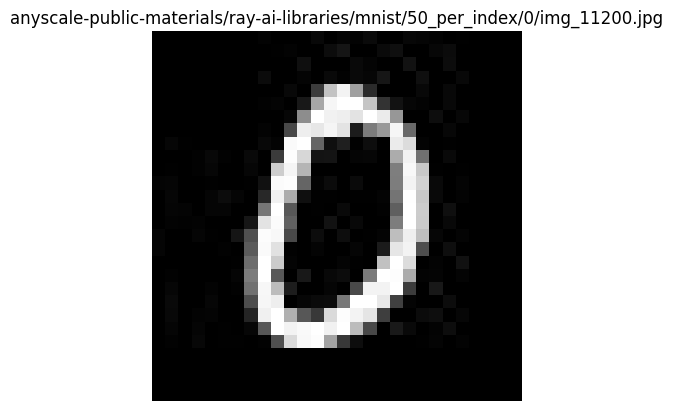

In [5]:
img = batch["image"][0]
title = batch["path"][0]

plt.title(title)
plt.axis("off")
plt.imshow(img, cmap='gray')

<div class="alert alert-block alert-info">

<b>Note on execution triggering methods in Ray Dataset</b>

To determine if an operation will trigger execution, look for the methods with the `ConsumptionAPI` decorator in the [`Dataset.py`](https://github.com/ray-project/ray/blob/master/python/ray/data/dataset.py).

These categories of operations trigger execution (with some examples):
* Method designed to consume Datasets for **writing**:
  * [`write_parquet`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.write_parquet.html#ray.data.Dataset.write_parquet)
* Method designed to consume Datasets for **distributed training**:
  * [`streaming_split`](https://github.com/ray-project/ray/blob/master/python/ray/data/dataset.py#L1694)
* Methods that attempt to **show** data, for example:
  * [`take`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.take.html#ray.data.Dataset.take)
  * [`show`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.show.html#ray-data-dataset-show)
* **Aggregations**, which attempt to reduce a dataset to a single value per column:
  * [`min`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.min.html#ray.data.Dataset.min)
  * [`sum`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.sum.html#ray.data.Dataset.sum)

Another way to trigger execution is to explicitly call <a href="https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.materialize.html#ray-data-dataset-materialize" target="_blank">materialize()</a>. This will execute the underlying plan and generate the entire data blocks onto the cluster's memory.

## 4. Transforming data

To transform data, we can use the [`map_batches`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html#ray-data-dataset-map-batches) API. 

`map_batches` takes a user-defined function which accepts a batch of data and returns a batch of transformed data.

In [6]:
def normalize(batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    batch["image"] = [transform(image) for image in batch["image"]]
    return batch

Calling `ds.map_batches` will add a `map_batches` operator to the execution plan.

In [7]:
ds_normalized = ds.map_batches(normalize)

To tune the batch size for the transformation, specify the `batch_size` parameter.  

In [8]:
ds_normalized = ds.map_batches(normalize, batch_size=32)

<div class="alert alert-block alert-info">

**Note:** batching only helps with performance when a transformation is vectorized - i.e. benefits from processing multiple rows at once.

Finding the optimal batch size depends on the hardware available and the target utilization.

</div>

### 4.1 On resource specification

To specify the exact resources to use for a `map_batches` transformation, specify the `num_cpus`, `num_gpus`, `memory`, and `resources` parameters.

- `num_cpus`: Number of CPUs to use for each task (use >1 if task performs multithreaded operations).
- `num_gpus`: Number of GPUs to use for each task.
- `memory`: Amount of RAM to use for each task (in bytes).
- `resources`: What is referred to as custom resources in Ray. It is a way to specify which node types to use for each task.

In [9]:
ds_normalized = ds.map_batches(normalize, batch_size=32, num_cpus=1, memory=100 * 1024**2)

<div class="alert alert-block alert-info">

**Note:** Ray only performs a logical allocation of resources and does not physically enforce resource limits.

By default, Ray will [retry OOM errors](https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html#retry-policy) and Ray Data will infinitely retry tasks that fail due to system failures.

Specifying resources helps avoid resource contention, avoiding unnecessary retries and confusing OOM errors.

</div>

### 4.2 On concurrency limiting

Ray Data will attempt to use all the resources available in the cluster. 

In particular, it will schedule as many tasks as there are input blocks for each operator (stage) in the pipeline.

To limit the concurrency for a particular transformation, specify the `concurrency` parameter.

In [10]:
concurrency_limit = 10  # Don't schedule more than 10 tasks at a time

ds_normalized = ds.map_batches(
    normalize,
    batch_size=32,
    num_cpus=1,
    memory=100 * 1024**2,
    concurrency=concurrency_limit,
)

<div class="alert alert-block alert-info">

**Note:** Limiting concurrency might be helpful when you have an unbounded compute configuration (max number of nodes is too high) and you want to avoid aggressive scaling for a fast step in the pipeline (e.g. light preprocessing of data).

Additionally, note that Ray Data will attempt to fuse transformations together to reduce data transfer between stages. Setting different concurrency limits for different transformations might prevent this optimization.

</div>

To verify the output of `normalize()`, call [`take_batch()`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.take_batch.html#ray.data.Dataset.take_batch) on the dataset.

In [11]:
normalized_batch = ds_normalized.take_batch(batch_size=10)

2026-01-07 18:59:08,996	INFO logging.py:290 -- Registered dataset logger for dataset dataset_6_0
2026-01-07 18:59:09,004	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_6_0. Full logs are in /tmp/ray/session_2026-01-07_18-21-07_210936_40870/logs/ray-data
2026-01-07 18:59:09,005	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_6_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage] -> TaskPoolMapOperator[MapBatches(normalize)] -> LimitOperator[limit=10]


Running 0: 0.00 row [00:00, ? row/s]

- ReadImage 1: 0.00 row [00:00, ? row/s]

- MapBatches(normalize) 2: 0.00 row [00:00, ? row/s]

- limit=10 3: 0.00 row [00:00, ? row/s]

2026-01-07 19:02:48,808	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_6_0 execution finished in 219.80 seconds


Check the normalized pixel value range:

In [12]:
for image in normalized_batch["image"]:
    assert image.shape == (1, 28, 28) # channel, height, width
    assert image.min() >= -1 and image.max() <= 1 # normalized to [-1, 1]

<div class="alert alert-block alert-info">

**Activity**

Add the ground truth label extracted from the image path.

Starting point:

```python
ds = ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", include_paths=True)
ds_normalized = ds.map_batches(normalize)
# batch = ds_normalized.take_batch(batch_size=3)

# add_label
ds_labeled = ds_normalized.map_batches(add_label)
labeled_batch = ds_labeled.take_batch(10)
print(labeled_batch)
```


**The task**

Implement `add_label` function that takes batch of data and return batch with image label.

The image path is in the format:`s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/{label}/{image_id}.png`.

**Hint**: Define the add_label function; use `take_batch()` to better understand the data format.
```
def add_label(batch):
    ...
    return batch
```

</div>

In [ ]:
def add_label(batch):
    labels = []
    for item in batch["path"]:
        label = int(item.split("/")[-2])
        labels.append(label)

    batch["label"] = np.array(labels)
    return batch

ds = ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", include_paths=True)
ds_normalized = ds.map_batches(normalize)
ds_labeled = ds_normalized.map_batches(add_label)
labeled_batch = ds_labeled.take_batch(10)
print(labeled_batch["label"])

2026-01-07 19:03:05,092	INFO logging.py:290 -- Registered dataset logger for dataset dataset_10_0
2026-01-07 19:03:05,097	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_10_0. Full logs are in /tmp/ray/session_2026-01-07_18-21-07_210936_40870/logs/ray-data
2026-01-07 19:03:05,098	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_10_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->MapBatches(normalize)->MapBatches(add_label)] -> LimitOperator[limit=10]


Running 0: 0.00 row [00:00, ? row/s]

- ReadImage->MapBatches(normalize)->MapBatches(add_label) 1: 0.00 row [00:00, ? row/s]

- limit=10 2: 0.00 row [00:00, ? row/s]

2026-01-07 19:03:05,128	WARNING progress_bar.py:120 -- Truncating long operator name to 100 characters. To disable this behavior, set `ray.data.DataContext.get_current().DEFAULT_ENABLE_PROGRESS_BAR_NAME_TRUNCATION = False`.
2026-01-07 19:04:55,422	INFO streaming_executor.py:220 -- ✔️  Dataset dataset_10_0 execution finished in 110.32 seconds


{'image': array([[[[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ]]],


       [[[-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         [-1.        , -1.        , -1.        , ..., -1.        ,
          -1.        , -1.        ],
         ...,
         [-1.        ,

<div class="alert alert-block alert-info">

<details>

<summary>Click to view solution</summary>

```python
def add_label(batch):
    labels = []
    for item in batch["path"]:
        label = int(item.split("/")[-2])
        labels.append(label)

    batch["label"] = np.array(labels)
    return batch

ds = ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", include_paths=True)
ds_normalized = ds.map_batches(normalize)
ds_labeled = ds_normalized.map_batches(add_label)
labeled_batch = ds_labeled.take_batch(10)
print(labeled_batch)
```

</details>  
</div>

## 5. Stateful transformations with Ray Actors

In cases like batch inference, you want to spin up a number of actor processes that are **initialized once** with your model **and reused** to process multiple batches.

To implement this, you can use the `map_batches` API with a "Callable" class method that implements:

- `__init__`: Initialize any expensive state.
- `__call__`: Perform the stateful transformation.

For example, we can implement a `MNISTClassifier` that:
- loads a pre-trained model from a local file
- accepts a batch of images and generates the predicted label

In [ ]:
device = "cpu" # "cuda", or "cpu" if you want to run it locally on CPU
class MNISTClassifier:
    def __init__(self, remote_path: str, local_path: str):
        subprocess.run(f"aws s3 cp --no-sign-request {remote_path} {local_path}", shell=True, check=True)

        self.model = torch.jit.load(local_path).to(device).eval()


    def __call__(self, batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
        images = torch.tensor(batch["image"]).float().to(device)

        with torch.no_grad():
            logits = self.model(images).cpu().numpy()

        batch["predicted_label"] = np.argmax(logits, axis=1)
        return batch

We can now use the `map_batches` API to apply the transformation to each batch of data.

In [ ]:
storage_folder = 'mnt/cluster_storage'  # Modify this path to your local folder if it runs on your local environment
local_path = f"{storage_folder}/model.pt"

mnist_classifier_args = {
    "remote_path": "s3://anyscale-public-materials/ray-ai-libraries/mnist/model/model.pt",
    "local_path": local_path,
}

ds_preds = ds_normalized.map_batches(
    MNISTClassifier,
    fn_constructor_kwargs=mnist_classifier_args,
    num_gpus= 1 if device == 'cuda' else None,  # Use GPU if available
    concurrency=3,
    batch_size=100,
)

### 5.1 Resource specification for stateful transformations

It is common when you have varying hardware types in your cluster to want to further specify which accelerators to use for each stage of your pipeline.

Let's show how to achieve this with the `resources` parameter.

To use a GPU for following examples, we suggest to run them on Anyscale Ray Cluster.

In [ ]:
ds_preds = ds_normalized.map_batches(
    MNISTClassifier,
    fn_constructor_kwargs=mnist_classifier_args,
    num_gpus= 1 if device == 'cuda' else None,  # Use GPU if available
    concurrency=3,
    batch_size=100,
    resources={"accelerator_type:T4": 0.0001},
)

<div class="alert alert-block alert-info">

<b>Note:</b> Pass in the Callable class uninitialized. Your driver will not execute the class constructor. Ray will pass in the arguments to the class constructor when the class is actually used in a transformation.


</div>

### 5.2 Note on autoscaling for stateful transformations

For stateless transformations, Ray Data will automatically scale up the number of tasks to match the number of input blocks.

For stateful transformations, Ray Data will schedule tasks proportional to the number of actors (workers) in the pool. 

To specify an autoscaling pool, use a tuple of `(min_size, max_size)` for the `concurrency` parameter.

Ray Data will start with `min_size` actors and automatically scale up to `max_size` as needed.





In [ ]:
ds_preds = ds_normalized.map_batches(
    MNISTClassifier,
    fn_constructor_kwargs=mnist_classifier_args,
    num_gpus= 1 if device == 'cuda' else None,  # Use GPU if available
    concurrency=(1, 4),  # Autoscale pool based on blocks, resources and limits
    batch_size=100,
    #resources={"accelerator_type:T4": 0.0001}, # Optional if you run it locally
)

In [ ]:
batch_preds = ds_preds.take_batch(100)
batch_preds

## 6. Materializing data

You can choose to materialize the entire dataset into the Ray object store which is distributed across the cluster, primarily in memory and secondarily spilling to disk.

To materialize the dataset, we can use the `materialize()` method.

Use this **only** when you require the full dataset to compute downstream outputs.

In [ ]:
ds_preds.materialize()

`materialize()` triggers the execution. The logs should show the execution plan of Dataset:

```
Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[MapBatches(normalize)] -> ActorPoolMapOperator[MapBatches(MNISTClassifier)]
```

## 7. Data Operations: grouping, aggregation, and shuffling

Let's look at some more involved transformations.

Some operations require all inputs to be materialized in object store. To determinte this, look for the methods with the `AllToAllAPI` decorator in the [`Dataset.py`](https://github.com/ray-project/ray/blob/master/python/ray/data/dataset.py).

### 7.1. Custom batching using `groupby`. 

In case you want to generate batches according to a specific key, you can use `groupby` to group the data by the key and then use `map_groups` to apply the transformation.

For instance, let's compute the accuracy of the model by "ground truth label".

In [ ]:
def add_label(batch: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    batch["ground_truth_label"] = [int(path.split("/")[-2]) for path in batch["path"]]
    return batch

def compute_accuracy(group: dict[str, np.ndarray]) -> dict[str, np.ndarray]:
    return {
        "accuracy": [np.mean(group["predicted_label"] == group["ground_truth_label"])],
        "ground_truth_label": group["ground_truth_label"][:1],
    }

In [ ]:
ds_preds.map_batches(add_label).groupby("ground_truth_label").map_groups(compute_accuracy).to_pandas()

<div class="alert alert-block alert-info">

<b>Note:</b> `ds_preds` is not re-computed given we have already materialized the dataset.

</div>

### 7.2. Aggregations

Ray Data also supports a variety of aggregations. For instance, we can compute the mean accuracy across the entire dataset.

In [ ]:
ds_preds.map_batches(add_label).map_batches(compute_accuracy).mean(on="accuracy")

Note: this is ConsumptionAPI

Ray Data provides collection of aggregation functions including:

- `count`
- `max`
- `mean`
- `min`
- `sum`
- `std`

See relevant [docs page here](https://docs.ray.io/en/latest/data/api/grouped_data.html#ray.data.aggregate.AggregateFn).

### 7.3. Shuffling data 

There are different options to shuffle data in Ray Data of varying degrees of randomness and performance.

#### 7.3.1. File based shuffle on read

To randomly shuffle the ordering of input files before reading, call a read function that supports shuffling, such as `read_images()`, and use the shuffle="files" parameter.

In [ ]:
ray.data.read_images("s3://anyscale-public-materials/ray-ai-libraries/mnist/50_per_index/", shuffle="files")

#### 7.3.2. Shuffling block order
This option randomizes the order of blocks in a dataset. Blocks are the basic unit of data chunk that Ray Data stores in the object store. Applying this operation alone doesn’t involve heavy computation and communication. However, it requires Ray Data to materialize all blocks in memory before applying the operation. Only use this option when your dataset is small enough to fit into the object store memory.

To perform block order shuffling, use `randomize_block_order`.

In [ ]:
ds_randomized_blocks = ds_preds.randomize_block_order()
ds_randomized_blocks.materialize()

#### 7.3.3. Shuffle all rows globally
To randomly shuffle all rows globally, call `random_shuffle()`. This is the slowest option for shuffle, and requires transferring data across network between workers. This option achieves the best randomness among all options.


In [ ]:
ds_randomized_rows = ds_preds.random_shuffle()
ds_randomized_rows.materialize()

## 8. Persisting data

Finally, you can persist a dataset to storage using any of the "write" functions that Ray Data supports.

Lets write our predictions to a parquet dataset.

In [ ]:
local_pred_folder = f"{storage_folder}/mnist_preds" # Change this to your local path if needed
ds_preds.write_parquet(local_pred_folder)

Refer to the [Input/Output docs](https://docs.ray.io/en/latest/data/api/input_output.html) for a comprehensive list of write functions.

## 9. Ray Data in production

- Netflix is using Ray Data for multi-modal inference pipelines. See [this talk at the Ray Summit 2024](https://raysummit.anyscale.com/flow/anyscale/raysummit2024/landing/page/sessioncatalog/session/1722028596844001bCg0) to learn more.
- Pinterest is using Ray Data and Ray Train for their recommendation system model training. They leverage Ray Data to improve GPU utilization and training throughput by disaggregating their compute across a heterogeneous cluster.  [this talk at the Ray Summit 2024](https://www.classcentral.com/course/youtube-pinterest-s-ml-evolution-distributed-training-with-ray-ray-summit-2024-353672) to learn more.

In [ ]:
# Run this cell for file cleanup 
!rm -rf {storage_folder}/mnist_preds
!rm {storage_folder}/model.pt